In [1]:
import tensorflow as tf
# import torch.optim as optim
import tensorflow.keras.optimizers as optim 
# import torch.nn as nn
import tensorflow.nn as nn
import matplotlib.pyplot as plt
# from utils import *
# from models.models import *
# ?from data.cifar import cifar_dimport mathataloaders
from time import sleep
# from data.cifar import cifar_dataloaders
# from utils import *

from tqdm import tqdm
import time
import math
import numpy as np
# data_loder
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MinMaxScaler
#model
import pandas as pd
from tensorflow import nn
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

from tensorflow.keras import layers

from copy import deepcopy

from tensorflow.keras import optimizers
from tensorflow.python.ops import math_ops, state_ops, control_flow_ops
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import random
import os
#resnet50
from tensorflow.keras.applications.resnet import ResNet50
from keras.models import Model

#Lapro
from tensorflow.python.ops import math_ops, state_ops, control_flow_ops
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 823418202185073766
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2236245607
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2170293289236228666
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


'''ensure same results observed across runs'''

In [2]:
'''ensure same results observed across runs'''
def ensure_reproducibility(seed):
    # Set the random seed for Python
    random.seed(seed)
    # Set the random seed for numpy
    np.random.seed(seed)
    # Set the random seed for TensorFlow
    tf.random.set_seed(seed)
    # Disable GPU visibility
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

'''ensure same results observed across runs'''

In [3]:
def cifar_dataloaders(batch_size=32):

    transform_train = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomCrop(32, 32),
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255),
        tf.keras.layers.experimental.preprocessing.Normalization(mean=[0.4914, 0.4822, 0.4465], variance=[0.2023, 0.1994, 0.2010]),
    ])

    transform_test = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255),
        tf.keras.layers.experimental.preprocessing.Normalization(mean=[0.4914, 0.4822, 0.4465], variance=[0.2023, 0.1994, 0.2010]),
    ])
    
    train_data, test_data = tfds.load(name='cifar10', split=['train', 'test'], shuffle_files=True, as_supervised=True, data_dir="./data")
    
    train_dataset = train_data.map(lambda image, label: (transform_train(image), label))
    train_dataset = train_dataset.shuffle(buffer_size=50000).batch(batch_size)

    test_dataset = test_data.map(lambda image, label: (transform_test(image), label))
    test_dataset = test_dataset.batch(batch_size)
    
    return train_dataset, test_dataset

#snake functions

In [4]:

class SnakeActivation(keras.layers.Layer):
    def __init__(self, a=1, **kwargs):
        super().__init__(**kwargs)
        self.a = a

    def call(self, inputs):
        return inputs + tf.square(tf.sin(self.a * inputs)) / self.a

class LearnedSnake(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.a = tf.Variable(tf.random.normal((1,)))

    def call(self, inputs):
        return inputs + tf.square(tf.sin(self.a * inputs)) / self.a

class SinActivation(tf.keras.layers.Layer):
    def __init__(self):
        super(SinActivation, self).__init__()

    def call(self, x):
        return tf.sin(x)

class SinPlusCosActivation(tf.keras.layers.Layer):
    def __init__(self):
        super(SinPlusCosActivation, self).__init__()

    def call(self, x):
        return tf.math.sin(x) + tf.math.cos(x)

class XPlusSinActivation(tf.keras.layers.Layer):
    def __init__(self):
        super(XPlusSinActivation, self).__init__()

    def call(self, x):
        return x + tf.math.sin(x)

Resnet50 model

In [5]:

'''ResNet18 with the specified activation. Since the CIFAR images
 aren't very large, the initial conv1 and maxpool layers are modified.'''

def ResNet50WithActivation(activation):
    resnet50 = ResNet50(include_top=False, input_shape=(None, None, 3))

    # modify the activation function in all layers
    for layer in resnet50.layers:
        if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.Dense):
            layer.activation = deepcopy(activation)

    # add a global average pooling layer and a dense output layer for classification
    x = layers.GlobalAveragePooling2D()(resnet50.output)
    x = layers.Dense(10, activation='softmax')(x)

    # create the new model
    model = Model(resnet50.input, x)

    return model

LaProp activation function

In [6]:
#LaProp
class LaProp(optimizers.Optimizer):
    def __init__(self, params, lr=4e-4, betas=(0.9, 0.999), eps=1e-15,
                 weight_decay=0, amsgrad=False, centered=False):
        self.steps_before_using_centered = 10

        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad, centered=centered)
        super(LaProp, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']
                centered = group['centered']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of learning rates
                    state['exp_avg_lr_1'] = 0.; state['exp_avg_lr_2'] = 0.
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = tf.zeros_like(p.data)
                    if centered:
                    # Exponential moving average of gradient values as calculated by beta2
                        state['exp_mean_avg_beta2'] = tf.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = tf.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if centered:
                    exp_mean_avg_beta2 = state['exp_mean_avg_beta2']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # Decay the first and second moment running average coefficient
                exp_avg_sq = exp_avg_sq * beta2 + (1 - beta2) * tf.square(grad)
                state['exp_avg_lr_1'] = state['exp_avg_lr_1'] * beta1 + (1 - beta1) * group['lr']
                state['exp_avg_lr_2'] = state['exp_avg_lr_2'] * beta2 + (1 - beta2)

                bias_correction1 = state['exp_avg_lr_1'] / group['lr'] if group['lr']!=0. else 1. #1 - beta1 ** state['step']
                step_size = 1 / bias_correction1

                bias_correction2 = state['exp_avg_lr_2']
                
                denom = exp_avg_sq
                if centered:
                    exp_avg_sq = exp_avg_sq * beta2 + (1 - beta2) * tf.square(grad)
                    if state['step'] > self.steps_before_using_centered:
                        mean = exp_mean_avg_beta2 ** 2
                        denom = denom - mean

                if amsgrad:
                    if not (centered and state['step'] <= self.steps_before_using_centered): 
                        # Maintains the maximum of all (centered) 2nd moment running avg. till now
                        torch.max()
                        max_exp_avg_sq = tf.math.maximum(max_exp_avg_sq, denom)
                        # Use the max. for normalizing running avg. of gradient
                        denom = max_exp_avg_sq

                denom = denom.div(bias_correction2).sqrt_().add_(group['eps'])
                step_of_this_grad = grad / denom
                exp_avg.assign(beta1 * exp_avg + (1 - beta1) * group['lr'] * step_of_this_grad)
                exp_avg = exp_avg * beta1 + (1 - beta1) * tf.square(grad)
                
                p.data.add_(-step_size, exp_avg )
                if group['weight_decay'] != 0:
                    p.data.add_( - group['weight_decay'], p.data)

        return loss

Train_model cifar

In [7]:
def train_cifar(model, train_dataloader, test_dataloader, epochs, verbose=False):
    train_losses = []
    test_losses = []

    train_accuracies = []
    test_accuracies = []

    optimizer = tf.keras.optimizers.Adam(learning_rate=4e-4)
    scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=4e-4, decay_steps=epochs//2, decay_rate=0.1)

    model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

    for epoch in tqdm(range(1, epochs+1)):
        train_loss_total = 0.0
        correct = 0
        num_steps = 0
        ### Train
        for i, batch in enumerate(train_dataloader):
            X, y = batch
            train_preds = model(X, training=True)

            loss = model.compiled_loss(y, train_preds)

            train_loss_total += loss.numpy().item()
            num_steps += 1

            train_preds = tf.argmax(train_preds, axis=1)
            correct += tf.reduce_sum(tf.cast(tf.equal(train_preds, y), tf.float32))

            with tf.GradientTape() as tape:
                # compute loss
                gradients = tape.gradient(loss, model.trainable_variables)
            model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))


        train_loss_total_avg = train_loss_total / num_steps
        train_accuracy = correct/(len(train_dataloader)*train_dataloader.batch_size)
        train_accuracies.append(train_accuracy.numpy())
        train_losses.append(train_loss_total_avg)

        test_loss_total = 0.0
        correct = 0
        num_steps = 0
        for i, batch in enumerate(test_dataloader):
            X, y = batch

            test_preds = model(X, training=False)
            loss = model.compiled_loss(y, test_preds)

            test_loss_total += loss.numpy().item()
            num_steps += 1

            test_preds = tf.argmax(test_preds, axis=1)
            correct += tf.reduce_sum(tf.cast(tf.equal(test_preds, y), tf.float32))

        test_loss_total_avg = test_loss_total / num_steps
        test_accuracy = correct/(len(test_dataloader)*test_dataloader.batch_size)
        test_accuracies.append(test_accuracy.numpy())
        test_losses.append(test_loss_total_avg)

        scheduler.learning_rate = model.optimizer.learning_rate.numpy()
        scheduler_decay = scheduler(epoch).numpy()
        tf.keras.backend.set_value(model.optimizer.lr, scheduler_decay)

        if verbose:
            print(f"Train accuracy on epoch {epoch}= {train_accuracies[-1]}")
            print(f"Test accuracy on epoch {epoch}= {test_accuracies[-1]}")

    return model, test_accuracies


<h2> CIFAR-10 with ResNet18

In [8]:
ensure_reproducibility(42)

In [20]:
activations_dict = {'tanh': tf.keras.activations.tanh, 
                    'Leaky ReLU': tf.keras.layers.LeakyReLU(), 
                    'sin': tf.math.sin, 
                    'swish': tf.keras.activations.swish, 
                    'ReLU': tf.keras.activations.relu, 
                    'snake, a = 0.5': SnakeActivation(0.5)}
len(activations_dict)

6

Configuration for training ResNet18 on CIFAR

In [39]:
BATCH_SIZE = 32
EPOCHS = 50

tanh <function tanh at 0x0000020EC1C4CB80>
Training ResNet18 on CIFAR with activation tanh
Epoch 1/50
313/313 [==============================] - 28s 75ms/step - loss: 2.2200 - accuracy: 0.2901 - val_loss: 2.5854 - val_accuracy: 0.1044
Epoch 2/50
313/313 [==============================] - 22s 72ms/step - loss: 1.7104 - accuracy: 0.3928 - val_loss: 3.0084 - val_accuracy: 0.1263
Epoch 3/50
313/313 [==============================] - 22s 72ms/step - loss: 1.5621 - accuracy: 0.4447 - val_loss: 2.3396 - val_accuracy: 0.2183
Epoch 4/50
313/313 [==============================] - 23s 72ms/step - loss: 1.7720 - accuracy: 0.3603 - val_loss: 2.1254 - val_accuracy: 0.2582
Epoch 5/50
313/313 [==============================] - 23s 73ms/step - loss: 1.8045 - accuracy: 0.3446 - val_loss: 2.2593 - val_accuracy: 0.2400
Epoch 6/50
313/313 [==============================] - 23s 73ms/step - loss: 1.7681 - accuracy: 0.3459 - val_loss: 2.0490 - val_accuracy: 0.2286
Epoch 7/50
313/313 [=========================

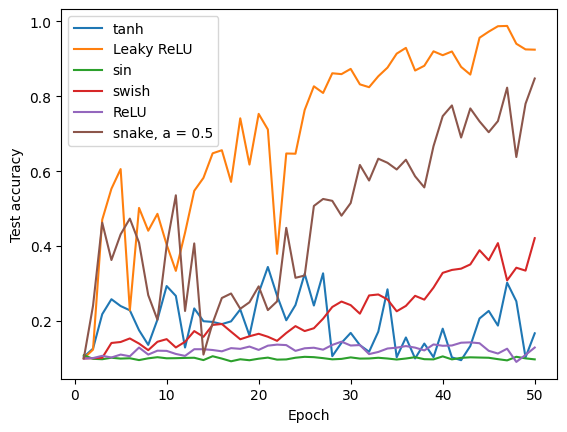

In [40]:
train_dl, test_dl = cifar_dataloaders(batch_size=BATCH_SIZE)
for act_name, act_func in activations_dict.items():
    print(act_name,act_func)
    model = ResNet50WithActivation(act_func)
    print(f"Training ResNet18 on CIFAR with activation {act_name}")
    # define optimizer
    optimizer = Adam(learning_rate=0.001)
    # compile model
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    # model, test_accuracies = train_cifar(model, train_dl, test_dl, epochs=EPOCHS, verbose=False)
    # train model
    history = model.fit(test_dl, epochs=EPOCHS, validation_data=test_dl)
    test_accs = history.history['val_accuracy']
    # loss_test, accuracy_test= model.evaluate(test_dl)
    plt.plot(range(1, EPOCHS+1), test_accs, label=act_name)

plt.xlabel("Epoch")
plt.ylabel("Test accuracy")
plt.legend()

In [173]:
loss_train, accuracy_train= model.evaluate(train_dl)

1563/1563 [==============================] - 26s 16ms/step - loss: 1434.7812 - accuracy: 0.1002


In [174]:
loss_train, accuracy_train

(1434.78125, 0.1001800000667572)

In [42]:
# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [114]:
y_pred = model.predict(test_dl)
y_true = np.concatenate([y for x, y in test_dl], axis=0)
test_accuracy = np.mean(y_pred.argmax(axis=1) == y_true)

313/313 [==============================] - 6s 15ms/step


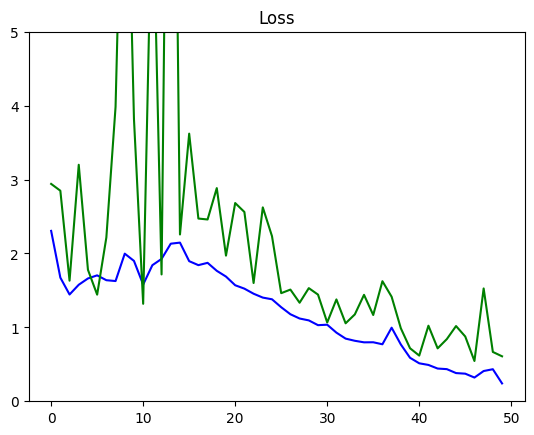

In [43]:
plot_metrics("loss", "Loss")

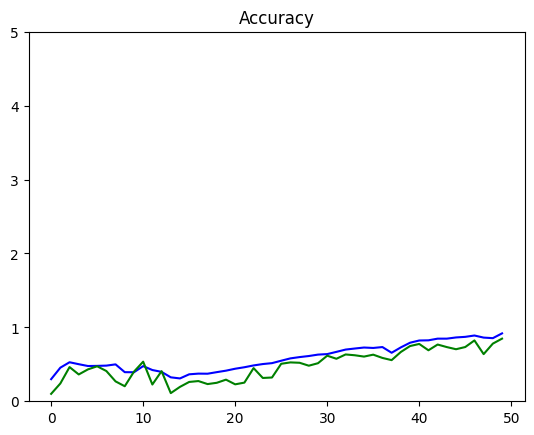

In [44]:
plot_metrics("accuracy", "Accuracy")